In [22]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import os

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
class BlockEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BlockEncoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            BlockEncoder(in_channels=in_channels, out_channels=32),
            BlockEncoder(in_channels=32, out_channels=64),
            BlockEncoder(in_channels=64, out_channels=64),
            nn.Flatten(),
            nn.Linear(in_features=64 * 8 * 8, out_features=latent_dim)
        )

    def forward(self, x):
        return self.model(x)

In [25]:
class BlockDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BlockDecoder, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_channels, 128 * 64 * 64),
            nn.ReLU(True),
        )

        self.conv = nn.Sequential(
            BlockDecoder(128, 64),
            BlockDecoder(64, 32),
            nn.ConvTranspose2d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 64, 64)
        x = self.conv(x)
        return x


In [26]:
class CAE(nn.Module):
    def __init__(self, in_channels, latent_dim, out_channels):
        super(CAE, self).__init__()

        self.encoder = Encoder(in_channels, latent_dim).to(device)
        self.decoder = Decoder(latent_dim, out_channels).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
# Hyper-parameter setting

in_channels=1
out_channels=1
latent_dim = 10
num_epochs = 5
batch_size = 128
learning_rate = 1e-4
b1 = 0.9
b2 = 0.99

# Loading the data

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

mnist_train = datasets.MNIST(root='./mnist_images', train=True, download=True, transform=transform)
mnist_dataset = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

if not os.path.exists('output_dir'):
    os.makedirs('output_dir')

model = CAE(in_channels=in_channels, out_channels=out_channels, latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(b1, b2))

for e in range(num_epochs):
    for i, (images, _) in enumerate(mnist_dataset):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('epoch [{}/{}], batch [{}/{}], loss:{:.4f}'
              .format(e + 1, num_epochs, i + 1, len(mnist_dataset), loss.item()))

        if i == len(mnist_dataset) - 1:
            pic = outputs.cpu().data
            save_image(pic, './output_dir/image_{}.png'.format(e + 1))

epoch [1/5], batch [1/469], loss:0.2472
epoch [1/5], batch [2/469], loss:0.2369
epoch [1/5], batch [3/469], loss:0.2275
epoch [1/5], batch [4/469], loss:0.2209
epoch [1/5], batch [5/469], loss:0.2148
epoch [1/5], batch [6/469], loss:0.2114
epoch [1/5], batch [7/469], loss:0.1995
epoch [1/5], batch [8/469], loss:0.1963
epoch [1/5], batch [9/469], loss:0.1889
epoch [1/5], batch [10/469], loss:0.1818
epoch [1/5], batch [11/469], loss:0.1761
epoch [1/5], batch [12/469], loss:0.1706
epoch [1/5], batch [13/469], loss:0.1664
epoch [1/5], batch [14/469], loss:0.1605
epoch [1/5], batch [15/469], loss:0.1543
epoch [1/5], batch [16/469], loss:0.1507
epoch [1/5], batch [17/469], loss:0.1442
epoch [1/5], batch [18/469], loss:0.1427
epoch [1/5], batch [19/469], loss:0.1388
epoch [1/5], batch [20/469], loss:0.1354
epoch [1/5], batch [21/469], loss:0.1305
epoch [1/5], batch [22/469], loss:0.1274
epoch [1/5], batch [23/469], loss:0.1270
epoch [1/5], batch [24/469], loss:0.1177
epoch [1/5], batch [25/46

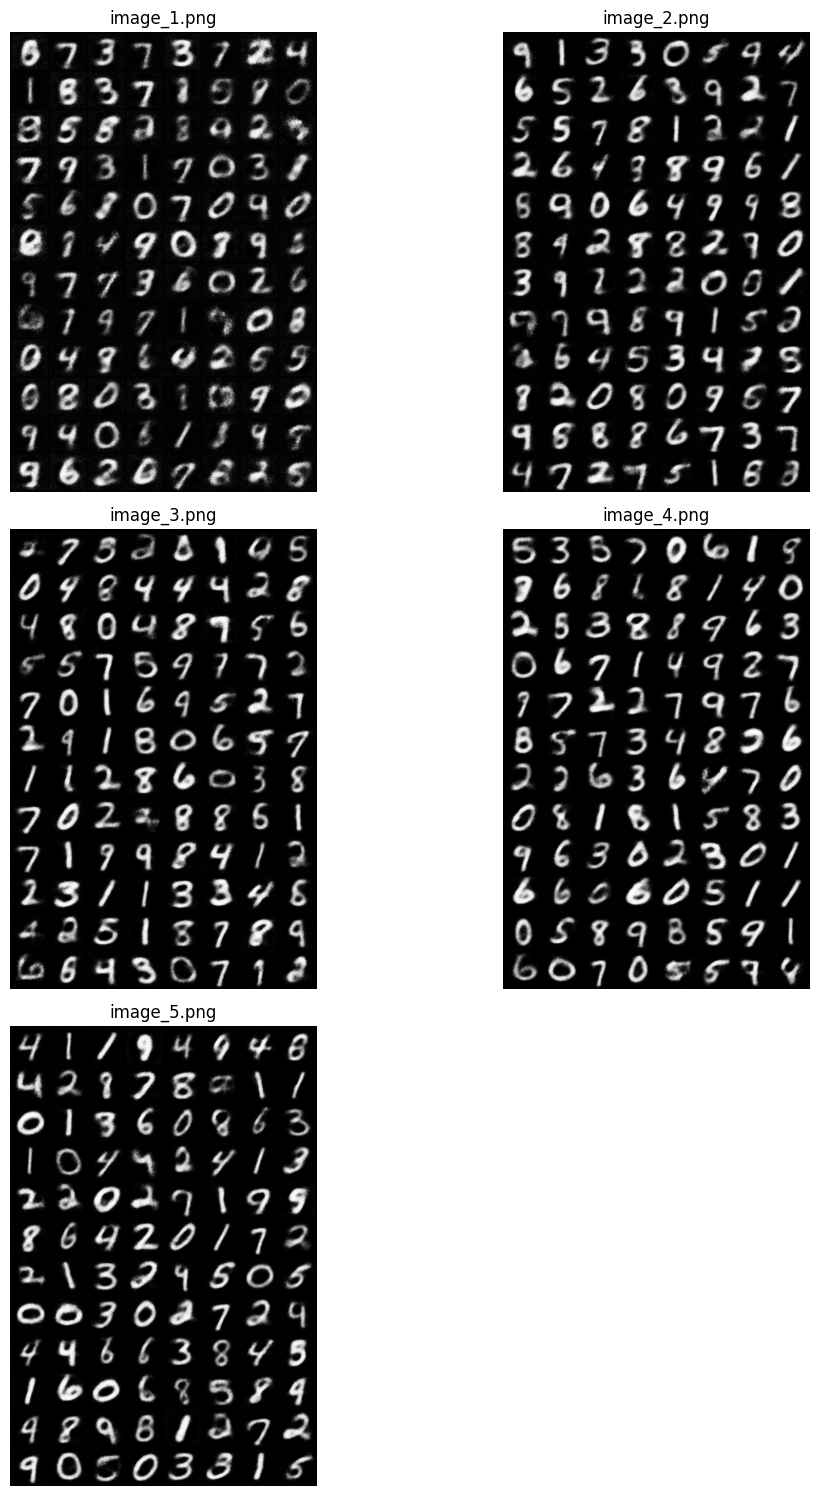

In [34]:
# prompt: plot the 5 images in the output_dir in 2 columns with their names alongside them.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Figure size in inches
fig = plt.figure(figsize=(10, 25))

# Two columns, five images
columns = 2
rows = 5

image_files = ['output_dir/image_' + str(i) + '.png' for i in range(1, 6)]

for i in range(1, 6):
    img = mpimg.imread(image_files[i - 1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(image_files[i - 1][11:])
    plt.axis('off')

plt.tight_layout()
plt.show()
